<a href="https://colab.research.google.com/github/Seydifa/Challenge/blob/main/CGIAR%20Volume%20estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
papitosen_cgiar_root_volume_estimation_challenge_dataset_path = kagglehub.dataset_download('papitosen/cgiar-root-volume-estimation-challenge-dataset')

print('Data source import complete.')

Data source import complete.


In [ ]:
!pip install timm ultralytics -qU

In [ ]:
from transformers.models.llama.modeling_llama import LlamaDecoderLayer, LlamaConfig, LlamaRotaryEmbedding
from transformers import PretrainedConfig, PreTrainedModel
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ultralytics import YOLO
import seaborn as sns
from glob import glob
from torch import nn
import pandas as pd
import numpy as np
import random
import torch
import timm
import os

In [ ]:
def draw_vertical_lines(image, n, start_color=(255, 0, 0), end_color=(0, 255, 0), line_width=1, font_size=40, overslap=0.1):
    draw = ImageDraw.Draw(image)
    width, height = image.size

    # Load a font with the specified size
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", font_size)  # Common WSL font
    except IOError:
        font = ImageFont.load_default()  # Fallback if the font file is not found

    # Calculate spacing between lines
    step = width / n
    overslap = int(step * overslap)
    number_colors = [(0, 0, 255), (0, 255, 0), (255, 165, 0), (128, 0, 128), (0, 255, 255)]  # Example colors

    # Draw the vertical lines
    for i in range(1, n):  # Exclude the first and last edges
        x_end = int(i * step) - overslap
        x_start = int(i * step)
        draw.line([(x_end, 0), (x_end, height)], fill=start_color, width=line_width)
        draw.line([(x_start, 0), (x_start, height)], fill=end_color, width=line_width)

    # Add numbers in each region with different colors
    for i in range(n):
        num_x = int((i + 0.5) * step)  # Center in the region
        num_y = height // 2  # Vertically centered
        num_color = random.choice(number_colors)  # Choose a random color
        text = str(i + 1)

        # Get text bounding box to adjust positioning
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]

        draw.text((num_x - text_width // 2, num_y - text_height // 2), text, fill=num_color, font=font)

    return image

def split_image(image, n, overslap=0.0, plant_idx=None):
    image = np.asarray(image)
    width, height, _ = image.shape
    step = height // n
    overslap = int(step * overslap)
    images = []
    for i in range(n):
        x_start = max(int(i*step) - overslap, 0)
        x_end = min(int((i+1)*step), height)
        crop = image[:, x_start:x_end]
        images.append(crop)

    if plant_idx is None:
        return images

    return images[plant_idx]

def merge_left_right(limg, rimg):

    # Ensure both images have the same width
    width = min(limg.width, rimg.width)
    _,height = limg.size
    limg = limg.crop((0, 0, width, height))
    _,height = rimg.size
    rimg = rimg.crop((0, 0, width, height))

    # Create a new image with combined height
    stacked_img = Image.new("RGB", (width, limg.height + rimg.height))

    # Paste images on top of each other
    stacked_img.paste(rimg.rotate(180), (0, 0))
    stacked_img.paste(limg, (0, rimg.height))

    return stacked_img

def stack_images_vertically(images):

    # Ensure all images have the same width by cropping to the smallest width
    min_width = min(img.width for img in images)
    images = [img.crop((0, 0, min_width, img.height)) for img in images]

    # Calculate total height
    total_height = sum(img.height for img in images)

    # Create a new image with combined height
    stacked_img = Image.new("RGB", (min_width, total_height))

    # Paste images on top of each other
    y_offset = 0
    for img in images:
        stacked_img.paste(img, (0, y_offset))
        y_offset += img.height

    # Save the stacked image
    return stacked_img

def see_all_plants(data_path, fname, s=8, e=61, side='L'):
    limgs = sorted(glob(f'{data_path}/{fname}/{fname}_L_*.png'))
    rimgs = sorted(glob(f'{data_path}/{fname}/{fname}_R_*.png'))

    if side == 'R':
        ims = [Image.open(i) for i in rimgs][s:e]
    elif side == 'L':
        ims = [Image.open(i) for i in limgs][s:e]
    else:
        rims = [Image.open(i) for i in rimgs][s:e] + [Image.open(i) for i in limgs][s:e]
        lims = [Image.open(i) for i in limgs][s:e] + [Image.open(i) for i in rimgs][s:e]

        ims = []
        for l,r in zip(lims, rims):
            i = merge_left_right(l,r)
            ims.append(i)
    return stack_images_vertically(ims)

In [ ]:
TRAIN_CSV = papitosen_cgiar_root_volume_estimation_challenge_dataset_path + '/Train (2).csv'
TEST_CSV = papitosen_cgiar_root_volume_estimation_challenge_dataset_path + '/Test (1).csv'

DATA_PATH = papitosen_cgiar_root_volume_estimation_challenge_dataset_path + '/data'
print(os.listdir(DATA_PATH))
TRAIN_DATA = DATA_PATH + '/train'
TEST_DATA = DATA_PATH + '/test'

print('Numbers of files in train', len(os.listdir(TRAIN_DATA)))
print('Numbers of files in test', len(os.listdir(TEST_DATA)))

['train', 'test']
Numbers of files in train 98
Numbers of files in test 62


In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

Train shape: (386, 9)
Test shape: (130, 8)


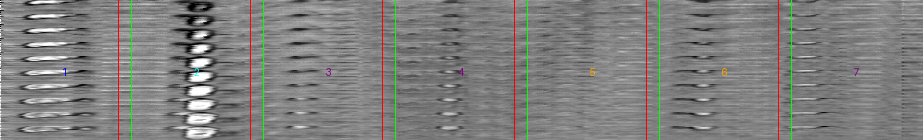

In [ ]:
folders = train_df.FolderName.value_counts().index.values
folder = 'Idiolerx47'
sample = train_df[train_df.FolderName == folder].to_dict('records')
img = see_all_plants(TRAIN_DATA, folder, s=sample[0]['Start'], e=sample[0]['End'], side=sample[0]['Side'])
img = draw_vertical_lines(img, 7, line_width=1, font_size=40, overslap=0.1)
img

In [ ]:
from IPython.display import display
# Train preprocessing
train_images = {}
DEPTH = 20
for row in tqdm(train_df.itertuples(), total=len(train_df)):
    folder = row.FolderName
    start = row.Start
    end = row.End
    if end - start < DEPTH:
        pad = DEPTH - (end - start)
        start -= pad // 2
        end += pad - pad // 2
    plant_idx = row.PlantNumber - 1
    side = row.Side
    img = see_all_plants(TRAIN_DATA, folder, s=start, e=end, side=side)
    try:
        img = split_image(img, 7, overslap=0.1, plant_idx=plant_idx)
    except:
      img = draw_vertical_lines(img, 7, line_width=1, font_size=40, overslap=0.1)
      display(img)
    train_images[row.ID] = img
# Test preprocessing
test_images = {}
for row in tqdm(test_df.itertuples(), total=len(test_df)):
  folder = row.FolderName
  start = row.Start
  end = row.End
  if end - start < DEPTH:
    pad = DEPTH - (end - start)
    start -= pad // 2
    end += pad - pad // 2
  plant_idx = row.PlantNumber - 1
  side = row.Side
  img = see_all_plants(TEST_DATA, folder, s=start, e=end, side=side)
  try:
      img = split_image(img, 7, overslap=0.1, plant_idx=plant_idx)
  except:
    img = draw_vertical_lines(img, 7, line_width=1, font_size=40, overslap=0.1)
    display(img)

  test_images[row.ID] = img

  0%|          | 0/386 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

In [ ]:
import  torchvision.transforms.v2 as transforms
# get model specific transforms (normalization, resize)
model_name = 'vit_so400m_patch14_siglip_384'
data_config = timm.data.resolve_model_data_config(model_name)
data_config['input_size'] = (3, 384, 384)
ttransforms = timm.data.create_transform(**data_config, is_training=True)
vtransforms = timm.data.create_transform(**data_config, is_training=False)

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    ttransforms
])

transform = transforms.Compose([
    transforms.ToPILImage(),
    vtransforms
])

def get_transformation(is_train=False):
    if is_train:
        return train_transform
    else:
        return transform

In [ ]:
train_df['Genotype'].unique()

array(['IITA-TMS-IBA000070', 'IBA154810', 'IBA980581', 'TMEB419', 'TMEB693', 'DIXON', 'IKN130010'], dtype=object)

In [ ]:
Stage_map = {'Early': 0, 'Late': 1}
Genotype_map = zip(train_df['Genotype'].unique(), range(len(train_df['Genotype'].unique())))
Genotype_map = dict(Genotype_map)
Genotype_map

{'IITA-TMS-IBA000070': 0,
 'IBA154810': 1,
 'IBA980581': 2,
 'TMEB419': 3,
 'TMEB693': 4,
 'DIXON': 5,
 'IKN130010': 6}

In [ ]:
class MixupDataset(torch.utils.data.Dataset):
    def __init__(self, meta_df, images, target_col='RootVolume', transform=None, alpha=0.2):
      self.meta_df = meta_df
      self.images = images
      self.target_col = target_col
      self.alpha = alpha
      self.transform = transform

    def get_random_sample(self):
        row = self.meta_df.sample(1).iloc[0]
        y = row[self.target_col]
        x = self.images[row['ID']]
        if self.transform:
          x = self.transform(x)
        return x, y

    def __call__(self, x, y):
        x2, y2 = self.get_random_sample()
        lam = np.random.beta(self.alpha, self.alpha)
        x = lam * x + (1 - lam) * x2
        y = lam * y + (1 - lam) * y2
        return x, y

class Dataset(torch.utils.data.Dataset):
    def __init__(self, meta_df, images, target_col='RootVolume', transform=None, mixup=False, alpha=0.2):
        """
        Args:
            meta_df (pd.DataFrame): DataFrame containing metadata with an 'ID' column and target_col.
            volumes: Dictionary mapping IDs to volume data (e.g., list or array of frames).
            target_col (str): Name of the target column in meta_df.
            transform: Transformation function to apply to each frame.
            mixup (bool): Whether to use mixup augmentation.
        """
        self.transform = transform
        self.target_col = target_col
        # Use a copy of the DataFrame to prevent unwanted side effects.
        self.meta_df = meta_df.copy()
        self.meta_df['Stage'] = self.meta_df['Stage'].astype('category').cat.codes.astype('int64')
        self.meta_df['Genotype'] = self.meta_df['Genotype'].astype('category').cat.codes.astype('int64')
        self.images = images
        if mixup:
            self.mixup_dataset = MixupDataset(self.meta_df, images, target_col=target_col, alpha=alpha, transform=transform)
        else:
            self.mixup_dataset = None

    def __len__(self):
        return self.meta_df.shape[0]

    def __getitem__(self, idx):
        # Get the sample metadata.
        sample = self.meta_df.iloc[idx]
        # Assume volume data is indexed by 'ID'.
        image = self.images[sample['ID']]
        # Get the target if available.
        target = sample.get(self.target_col, None)
        categories = [sample.Stage, sample.Genotype]
        categories = torch.tensor(categories, dtype=torch.long)
        # If a transformation is provided, apply it to each frame in volume.
        if self.transform:
            image = self.transform(image)
        # Apply mixup with 50% probability.
        if self.mixup_dataset and np.random.rand() < 0.5:
            image, target = self.mixup_dataset(image, target)
        # Return dictionary with required keys.
        if self.target_col is None:
            return {'pixel_values': torch.as_tensor(image), 'categories': categories}
        else:
            return {'pixel_values': torch.as_tensor(image), 'categories': categories, 'labels': torch.as_tensor(target)}

In [ ]:
ds = Dataset(train_df.sample(frac=1.0), train_images, transform=get_transformation(is_train=True), mixup=True)
dataloader = torch.utils.data.DataLoader(ds, batch_size=16, shuffle=True)

In [ ]:
v = next(iter(dataloader))
v['categories']

tensor([[0, 2],
        [0, 1],
        [0, 1],
        [0, 2],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 5],
        [0, 6],
        [0, 3],
        [0, 0],
        [0, 6],
        [1, 5],
        [0, 2],
        [0, 5],
        [0, 3]])

In [ ]:
# ---------------------------
# Configuration
# ---------------------------
class RootEstimatorConfig(PretrainedConfig):
    config_class = PretrainedConfig

    def __init__(self, projection_dim=256, feature_extractor='resnet18', num_layers=1, dropout=0.0, num_attention_heads=8, use_flash_attention=True, max_depth=250, **kwargs):
        """
        Args:
            projection_dim (int): Dimensionality used both for FPN output and LSTM input.
            feature_extractor (str): Backbone model name for timm.
            num_layers (int): Number of layers in the LSTM.
            dropout (float): Dropout probability applied before the final head.
        """
        super().__init__(**kwargs)
        self.projection_dim = projection_dim
        self.feature_extractor = feature_extractor
        self.num_layers = num_layers
        self.dropout = dropout
        self.max_depth = max_depth
        self.llama_config = LlamaConfig(
            hidden_size=projection_dim,
            intermediate_size=projection_dim * 2,
            num_hidden_layers=num_layers,
            num_attention_heads=num_attention_heads,
            attention_dropout=dropout,
            use_flash_attention=use_flash_attention,
        )

# ---------------------------
# Pyramid Feature Extractor (FPN)
# ---------------------------
class PyramidFeatureExtractor(nn.Module):
    """
    A simple FPN that uses lateral 1x1 convolutions and a top-down pathway to fuse
    multi-scale features into a single feature map.
    """
    def __init__(self, in_channels_list, out_channels):
        """
        Args:
            in_channels_list (list[int]): List of channel dimensions for each feature map.
            out_channels (int): The desired number of output channels.
        """
        super().__init__()
        self.lateral_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels),  # Added BN
                nn.ReLU()
            ) for in_ch in in_channels_list
        ])
        self.fpn_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),  # Added BN
                nn.ReLU()
            ) for _ in in_channels_list
        ])

    def forward(self, features):
        """
        Args:
            features (list[Tensor]): List of feature maps from the backbone.
                                     Assumes features are ordered from high-resolution
                                     to low-resolution.
        Returns:
            Tensor: Fused feature map of shape (B, out_channels, H, W), where H and W
                    match the resolution of the highest-resolution feature.
        """
        # Apply lateral convolutions.
        laterals = [l_conv(f) for f, l_conv in zip(features, self.lateral_convs)]
        # Top-down pathway: upsample and add.
        for i in range(len(laterals) - 1, 0, -1):
            upsampled = nn.functional.interpolate(laterals[i],
                                                    size=laterals[i - 1].shape[-2:],
                                                    mode='nearest')
            laterals[i - 1] = laterals[i - 1] + upsampled
        # Apply 3x3 convolutions.
        outs = [fpn_conv(lat) for lat, fpn_conv in zip(laterals, self.fpn_convs)]
        # Upsample all feature maps to the resolution of the highest-resolution feature and fuse (sum).
        out_size = outs[0].shape[-2:]
        outs_upsampled = [outs[0]] + [
            nn.functional.interpolate(o, size=out_size, mode='nearest')
            for o in outs[1:]
        ]
        fused = torch.mean(torch.stack(outs_upsampled, dim=0), dim=0)
        return fused

#----------------------------
# Cross Attention with Adapted
#-------------------------------
class CrossAttention(nn.Module):
    def __init__(self, projection_dim, num_heads=8, kv_bias=False, dropout=0.0):
        super().__init__()
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.mha = nn.MultiheadAttention(projection_dim, num_heads, add_bias_kv=kv_bias, dropout=dropout, batch_first=True)
        self.alpha = nn.Linear(projection_dim, 1)
        self.llayernorm = nn.LayerNorm(projection_dim)

    def forward(self, categorie_seq, feature_seq):
        residual = feature_seq
        feature_seq = self.llayernorm(feature_seq)
        attention_seq, _ = self.mha(
            query=feature_seq,
            key=feature_seq,
            value=feature_seq,
            key_padding_mask=None,
            need_weights=False,
            attn_mask=None,
            is_causal=False,
        )
        gate = torch.sigmoid(self.alpha(attention_seq))
        feature_seq = residual + gate * attention_seq
        return feature_seq

# ---------------------------
# Root Estimator Model with Pyramid Features
# ---------------------------
class RootEstimator(PreTrainedModel):
    config_class = RootEstimatorConfig

    def __init__(self, config, **kwargs):
        super().__init__(config, **kwargs)
        # Create the backbone with features_only=True to extract intermediate features.
        self.backbone = timm.create_model(
            config.feature_extractor,
            pretrained=True,
            in_chans=3,
            features_only=True,
        )
        self.freeze_backbone()
        # Get the list of number of channels for each feature map.
        in_channels_list = [f["num_chs"] for f in self.backbone.feature_info]
        # Define the pyramid (FPN) module to fuse multi-scale features.
        self.fpn = PyramidFeatureExtractor(in_channels_list, config.projection_dim)
        self.positional_encoding = nn.Embedding(config.max_depth, config.projection_dim)
        self.positional_dropout = nn.Dropout(config.dropout)
        # Add a normalization layer after global pooling from FPN.
        self.rotary_emb = LlamaRotaryEmbedding(config.llama_config)
        self.decoder_layers =  nn.ModuleList([
            LlamaDecoderLayer(config.llama_config, layer_idx) for layer_idx in range(config.num_layers)
        ])
        self.cross_attention = CrossAttention(config.projection_dim, num_heads=config.llama_config.num_attention_heads, kv_bias=False, dropout=config.dropout)
        # Final head for regression (output single value per example).
        self.head = nn.Sequential(
            nn.Linear(config.projection_dim, config.projection_dim*4),
            nn.GELU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.projection_dim*4, config.projection_dim),
            nn.Linear(config.projection_dim, 1)
        )
        self.genotype_embedding = nn.Embedding(len(Genotype_map)+1, config.projection_dim)
        self.stage_embedding = nn.Embedding(len(Stage_map)+1, config.projection_dim)

    def freeze_backbone(self):
        for param in self.backbone.parameters():
            param.require_grad = False
        print("backbone freeze !!!")

    def forward(self, pixel_values, categories, labels=None):
        """
        Args:
            pixel_values (Tensor): Input video frames of shape (B, T, H, W, C).
                                   Expected to be channels-last (C=3). They will be
                                   converted to channels-first.
            labels (Tensor, optional): Target values for computing loss.
        Returns:
            dict: Dictionary with keys 'logits' (model output) and optionally 'loss'.
        """
        x = pixel_values.float()  # (B, C, H, W)
        categories_emb_1 = self.genotype_embedding(categories[:, 1])
        categories_emb_2 = self.stage_embedding(categories[:, 0])
        c = torch.cat([categories_emb_1.unsqueeze(1), categories_emb_2.unsqueeze(1)], dim=1)
        # ---- Process All Frames in a Batch Efficiently ----
        # Merge batch and time dimensions for backbone processing.
        batch_size, C, H, W = x.shape
        # ---- Process All Frames in a Batch Efficiently ----
        # Merge batch and time dimensions for backbone processing.
        x_reshaped = x.view(batch_size, C, H, W)  # (B, C, H, W)
        # Extract multi-scale features for all frames.
        with torch.no_grad():
          features_list = self.backbone(x_reshaped)  # list of Tensors, each (B*T, ch, H_i, W_i)
        # Fuse pyramid features.
        fused = self.fpn(features_list)  # (B, projection_dim, H_fpn, W_fpn)
        # Global average pooling to obtain a single feature vector per frame.
        pooled = fused.mean(dim=-1)  # (B, H_i, projection_dim)
        # Reshape back to (B, T, projection_dim)
        features_seq = pooled.permute((0, 2, 1))
        features_seq = self.cross_attention(c, features_seq)
        # -----------------------------------------------------
        batch_size, feature_dim, projection_dim = features_seq.shape
        # create positional embedding
        position_ids = torch.arange(feature_dim, device=features_seq.device)
        position_ids = position_ids.unsqueeze(0)
        pos = self.positional_encoding(position_ids)
        pos = pos.squeeze(-1)
        # Dropout the positional embedding
        pos = self.positional_dropout(pos)
        # Add the positional embedding to the feature sequence.
        features_seq = features_seq + pos
        # Create position embedding accross all decoder layers
        position_embeddings = self.rotary_emb(features_seq, position_ids)
        # -----------------------------------------------------
        for decoder_layer in self.decoder_layers:
            features_seq = decoder_layer(features_seq, position_embeddings=position_embeddings)
            if isinstance(features_seq, tuple):
                features_seq = features_seq[0]
        # -----------------------------------------------------
        aggregated = features_seq.mean(dim=1)  # (B, projection_dim)
        logits = self.head(aggregated).squeeze(-1)  # (B,)

        loss = None
        if labels is not None:
            labels = labels.float()
            loss = nn.MSELoss()(logits, labels)
        return {'loss': loss, 'logits': logits}

In [ ]:
config = RootEstimatorConfig(
    feature_extractor=model_name,
    dropout=0.5,
    num_layers=2,
    projection_dim=256,
    num_attention_heads=16,
    use_flash_attention=True,
)

In [ ]:
from sklearn.metrics import root_mean_squared_error, mean_squared_error
def compute_metrics_fn(eval_pred, scaler=None):
    """
    Computes Mean Squared Error (MSE) between predictions and labels.

    Args:
        eval_pred (EvalPrediction): An object with two attributes:
            - predictions: The predicted values (typically as logits).
            - label_ids: The ground truth values.

    Returns:
        dict: A dictionary with the key "mse" mapping to the computed MSE.
    """
    predictions, labels = eval_pred.predictions, eval_pred.label_ids

    # In case the model returns a tuple (or extra outputs), we use the first element.
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # Ensure predictions have the correct shape.
    predictions = np.squeeze(predictions)
    labels = np.squeeze(labels)

    if scaler:
        predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        labels = scaler.inverse_transform(labels.reshape(-1, 1)).flatten()

    predictions = np.expm1(predictions)
    labels = np.expm1(labels)

    mse = mean_squared_error(labels, predictions)
    rmse = root_mean_squared_error(labels, predictions)
    return {"mse": mse, 'rmse': rmse}

In [ ]:
from datetime import datetime
from transformers import TrainingArguments
from transformers import Trainer

args = TrainingArguments(
    run_name='Run',
    output_dir='./results',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=100,
    warmup_steps=16,
    weight_decay=0.01,
    learning_rate=3e-5,
    logging_dir='./logs',
    logging_steps=2,
    report_to='none',
    eval_strategy='epoch',
    metric_for_best_model='rmse',
    save_total_limit=1,
    load_best_model_at_end=True,
    greater_is_better=False,
    save_strategy='epoch',
    lr_scheduler_type='cosine'
)

In [ ]:
def reset_cuda_session():
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    torch._C._cuda_emptyCache()

def count_trainable_params(model):
    # Count the trainable parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params:,}")

In [ ]:
from sklearn.model_selection import KFold, GroupKFold
# ---------------------------
# Initialize KFold with correct parameters.
# ---------------------------
kfold = GroupKFold(n_splits=4, shuffle=True, random_state=42)
predictions_df = None

for fold, (train_indices, valid_indices) in enumerate(kfold.split(train_df, train_df['Stage'], train_df['Genotype'])):
    print(f"\n--- Fold {fold + 1} ---")

    # Use iloc for both train and validation splits.
    df_train, df_valid = train_df.iloc[train_indices].copy(), train_df.iloc[valid_indices].copy()
    print(f"Train indices: {len(train_indices)} samples, Valid indices: {len(valid_indices)} samples")

    df_train['RootVolume'] = df_train['RootVolume'].clip(0, 5.0)
    df_train['RootVolume'] = np.log1p(df_train['RootVolume'])
    df_valid['RootVolume'] = np.log1p(df_valid['RootVolume'])

    # Create training and validation datasets.
    train_ds = Dataset(df_train, train_images, transform=get_transformation(is_train=True), mixup=True)
    valid_ds = Dataset(df_valid, train_images, transform=get_transformation(is_train=False))
    print('Train size:', len(train_ds), 'Valid size:', len(valid_ds))

    # Instantiate the model and count trainable parameters.
    model = RootEstimator(config)
    count_trainable_params(model)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        compute_metrics=compute_metrics_fn,
    )

    print("Starting training on fold", fold + 1)
    trainer.train()
    print("Training completed for fold", fold + 1)

    # Evaluate on test set.


--- Fold 1 ---
Train indices: 292 samples, Valid indices: 94 samples
Train size: 292 Valid size: 94


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


backbone freeze !!!
Total trainable parameters: 439,082,610
Starting training on fold 1


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.666000,0.391005,2.914476,1.707184
2,0.312400,0.220402,1.752214,1.323712
3,0.284000,0.151356,1.380273,1.174850
4,0.119300,0.155055,1.381817,1.175507
5,0.229600,0.161649,1.354488,1.163825
6,0.196500,0.159565,1.381894,1.175540
7,0.170700,0.157230,1.374982,1.172596
8,0.155300,0.169455,1.409738,1.187324
9,0.220700,0.237428,1.836374,1.355129
10,0.116500,0.170127,1.527895,1.236080
